In [9]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split


'''
Step 1: Split the dataset into training and testing sets
'''

# Creating Yes Sarcasm DataFrame
sarcasm_audio_files = glob.glob("audio_extracted_yes/*.mp3", recursive=True)
sarcasm_audio_df = pd.DataFrame(columns=["audio", "sarcasm"])
sarcasm_audio_df["audio"] = sarcasm_audio_files 
sarcasm_audio_df["sarcasm"] = True


# Creating Not Sarcasm DataFrame
not_sarcasm_audio_files = glob.glob("audio_extracted_no/*.mp3", recursive=True)
not_sarcasm_audio_df = pd.DataFrame(columns=["audio", "sarcasm"])
not_sarcasm_audio_df["audio"] = not_sarcasm_audio_files 
not_sarcasm_audio_df["sarcasm"] = False

#Splitting Dataset 70% training 30% testing
x_sarcasm_train, x_sarcasm_test, y_sarcasm_train, y_sarcasm_test = train_test_split(sarcasm_audio_df["audio"], sarcasm_audio_df["sarcasm"], test_size = 0.3)
x_not_sarcasm_train, x_not_sarcasm_test, y_not_sarcasm_train, y_not_sarcasm_test = train_test_split(not_sarcasm_audio_df["audio"], not_sarcasm_audio_df["sarcasm"], test_size = 0.3)

#Concat Sarcasm and Not Sarcasm Dataframe
x_train = pd.concat([x_sarcasm_train, x_not_sarcasm_train])
x_test = pd.concat([x_sarcasm_test, x_not_sarcasm_test])
y_train = pd.concat([y_sarcasm_train, y_not_sarcasm_train])
y_test = pd.concat([y_sarcasm_test, y_not_sarcasm_test])

#Reset Index to start with Index 0
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#Print Len to check if correctly splitted
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))



482
208
482
208


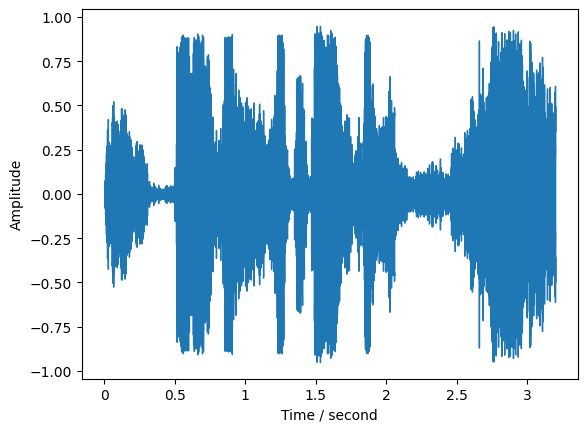

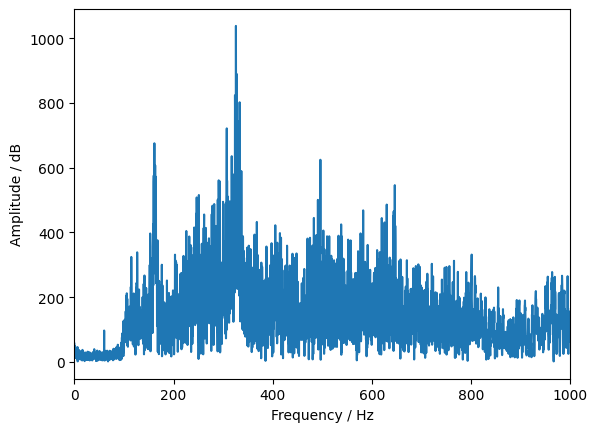

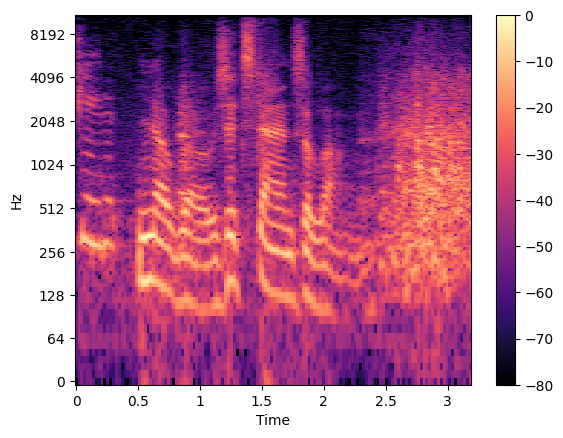

In [10]:
'''
Step 2: Exploratory Data Analysis
'''

from IPython.display import Audio

# plot audio files in time domain
signal, sample_rate = librosa.load(x_train.iloc[0])
plt.figure(1)
librosa.display.waveshow(y=signal, sr=sample_rate)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

# plot audio files in frequency domain
k = np.arange(len(signal))
T = len(signal)/sample_rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()


# plot the time-frequency variation of the audio
D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

Audio(data=signal ,rate=sample_rate)

In [11]:
'''
Step 3: Acoustic Feature Extraction 
&
Step 4: Feature Post-processing
'''

from sklearn.preprocessing import MinMaxScaler
numWindow = 20
scale = MinMaxScaler(feature_range=(-1,1))
def feature_extractor(audio_file):
    signal, sample_rate = librosa.load(audio_file)
    
    # audio feature extraction: loudness
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    df_loudness['Loudness'] = scale.fit_transform(pd.DataFrame(df_loudness['Loudness']))

    # audio feature extraction: mel-frequency cepstral coefficients
    df_mfccs = pd.DataFrame()
    # print(df_mfccs)
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc= numWindow)
    for n_mfcc in range(len(mfccs)):
        if(len(mfccs[n_mfcc]) < numWindow):
            df_mfccs['MFCC_%d'%(n_mfcc+1)] = librosa.util.pad_center(mfccs[n_mfcc], size = numWindow, mode='constant').T
        else:
            df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = scale.fit_transform(pd.DataFrame(df_mfccs['MFCC_%d'%(n_mfcc+1)]))


    # audio feature extraction: zero crossing rate
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    df_zero_crossing_rate['ZCR'] = scale.fit_transform(pd.DataFrame(df_zero_crossing_rate['ZCR']))

    # audio feature extraction: chroma
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate, n_chroma=numWindow)
    for n_chroma in range(len(chromagram)):
        if len(chromagram[n_chroma]) < numWindow:
            df_chroma['Chroma_%d'%(n_chroma+1)] = librosa.util.pad_center(chromagram[n_chroma], size = numWindow, mode='constant')
        else:
            df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
        df_chroma['Chroma_%d'%(n_chroma+1)] = scale.fit_transform(pd.DataFrame(df_chroma['Chroma_%d'%(n_chroma+1)]))

    # audio feature extraction: mel spectrogram
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=numWindow)
    for n_mel in range(len(mel_spectrogram)):
        if len(mel_spectrogram[n_mel]) < numWindow:
            df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = librosa.util.pad_center(mel_spectrogram[n_mel], size = numWindow, mode='constant').T
        else:
            df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)]= scale.fit_transform(pd.DataFrame(df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)]))

    # combine all features
    feature_matrix = pd.concat([df_loudness.head(numWindow), df_mfccs, df_zero_crossing_rate.head(numWindow), df_chroma, df_mel_spectrogram], axis=1)
    feature_matrix['mean'] = feature_matrix.mean(axis=1)

    return feature_matrix['mean']


x_train_df = pd.DataFrame()
for row in x_train:

    # row = x_train.iloc[val]
    # x_train_df = x_train_df.append(feature_extractor(row), ignore_index=True)
    x_train_df = pd.concat([x_train_df, pd.DataFrame([feature_extractor(row)])], ignore_index=True)
x_train = x_train_df

x_test_df = pd.DataFrame()
for row in x_test:
    # x_test_df = x_test_df.append(feature_extractor(row), ignore_index=True)
    x_test_df = pd.concat([x_test_df, pd.DataFrame([feature_extractor(row)])], ignore_index=True)
x_test = x_test_df

print(x_train)
print(x_test)


/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_33538/4074193448.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix['mean'] = feature_matrix.mean(axis=1)
/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_33538/4074193448.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix['mean'] = feature_matrix.mean(axis=1)
/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_33538/4074193448.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

           0         1         2         3         4         5         6    
0   -0.850858 -0.100113 -0.213668  0.049603 -0.343965 -0.300904 -0.254126  \
1   -0.824702 -0.008810 -0.184495  0.028764 -0.192134 -0.028619 -0.270729   
2   -0.782350 -0.022972 -0.085770 -0.329257 -0.235229 -0.299423 -0.496378   
3   -0.506760 -0.004147 -0.627397 -0.446137 -0.611329 -0.498440 -0.493310   
4   -0.449402  0.183089 -0.166572 -0.086945 -0.192991 -0.149047 -0.295370   
..        ...       ...       ...       ...       ...       ...       ...   
477 -0.601953  0.106355 -0.137632 -0.149023 -0.037063 -0.121110 -0.303624   
478 -0.578717  0.226071  0.118592 -0.101429 -0.180086 -0.237409 -0.294756   
479 -0.850297 -0.106988 -0.119842 -0.307748 -0.259406 -0.155287 -0.189428   
480 -0.613751 -0.607926 -0.611377 -0.616501 -0.615678 -0.617320 -0.616252   
481 -0.795650 -0.158222 -0.505778 -0.093331 -0.108240 -0.373761 -0.425565   

           7         8         9   ...        30        31        32   
0  

/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_33538/4074193448.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix['mean'] = feature_matrix.mean(axis=1)


In [12]:
'''
Step 5: Build your audio emotion recognition model
'''

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

svc.fit(x_train, y_train)
nbc.fit(x_train, y_train)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [13]:
y_svc_predicted = svc.predict(x_test)
print(classification_report(y_test, y_svc_predicted))

y_nbc_predicted = nbc.predict(x_test)
print(classification_report(y_test, y_nbc_predicted))

y_rfc_predicted = rfc.predict(x_test)
print(classification_report(y_test, y_rfc_predicted))

              precision    recall  f1-score   support

       False       0.58      0.65      0.61       104
        True       0.60      0.52      0.56       104

    accuracy                           0.59       208
   macro avg       0.59      0.59      0.58       208
weighted avg       0.59      0.59      0.58       208

              precision    recall  f1-score   support

       False       0.55      0.71      0.62       104
        True       0.59      0.41      0.49       104

    accuracy                           0.56       208
   macro avg       0.57      0.56      0.55       208
weighted avg       0.57      0.56      0.55       208

              precision    recall  f1-score   support

       False       0.57      0.60      0.58       104
        True       0.58      0.55      0.56       104

    accuracy                           0.57       208
   macro avg       0.57      0.57      0.57       208
weighted avg       0.57      0.57      0.57       208

